In [13]:
import numpy as np
import scipy.constants
import LaserParameters, BBOParameters

import matplotlib.pyplot as plt

In [14]:
plt.style.use('dark_background')
savedir = '/workspaces/BBO-Optimal-Parameters/plots/'

## Introduction

BBO is...

## Birefrigency

## Phase Matching

## Thickness optimization

### Effective second order nonlinear coefficient

### Loading all the physical constants

In [15]:
c = scipy.constants.c
epsilon_0 = scipy.constants.epsilon_0

In [16]:
Laser1550 = LaserParameters.TopticaLaser1550()
#deffTypeI = BBOParameters.deffTypeI

In [17]:
def RungeKutta4(F, t, y0, *args):
    N = len(t)
    h = t[1] - t[0]

    y = np.zeros( (N, len(y0)) )
    y[0] = y0
    for j in range(N-1):
        k1 = F(y[j], t[j], *args)
        k2 = F(y[j] + k1*h/2., t[j] + h/2., *args)
        k3 = F(y[j] + k2*h/2., t[j] + h/2., *args)
        k4 = F(y[j] + k3*h, t[j] + h, *args)
        y[j+1] = y[j] + (h/6.)*(k1 + 2*k2 + 2*k3 + k4)
                 
    return y

In [18]:
def SHG_RungeKuttaFunction(y, t, Delta_s):
    v1 = y[0]*y[1]*np.sin(y[2])
    v2 = -y[0]**2*np.sin(y[2])
    v3 = Delta_s+np.cos(y[2])*(2*y[1]**2-y[0]**2)/y[1]
    
    return np.array([v1,v2,v3])

In [19]:
no2_1550, ne2_1550 = BBOParameters.n2_Nikogosyan(1.55)
no2_775, ne2_775 = BBOParameters.n2_Nikogosyan(0.775)

#theta = 19.32*np.pi/180
theta = BBOParameters.PhaseMatchingAngle(no2_1550, ne2_1550, no2_775, ne2_775)
phi = -90*np.pi/180

n_1550 = np.sqrt(no2_1550)#ne_angle(no2_1550, ne2_1550, theta)
n_775 = BBOParameters.ne_angle(no2_775, ne2_775, theta)

omega_1550 = 2*np.pi*scipy.constants.lambda2nu(1550e-9)
Delta_K = 2*omega_1550*(n_1550 - n_775)/c

Power = Laser1550.peak_power
Waist = 0.01e-3
I = Power/(np.pi*Waist**2) #needs improvement
d_eff = 4e-11*BBOParameters.deffTypeI(theta, phi, -0.5) #needs improvement

characteristic_length = np.sqrt(2*n_1550**2*n_775/(epsilon_0*c*I))*c/(2*omega_1550*np.abs(d_eff))

In [20]:
n_1550

1.6465863905897784

In [21]:
u_tot = 1
u1_0 = 0.999
u2_0 = np.sqrt(u_tot**22-u1_0**2)
y0 = np.array([u1_0,u2_0,0])
z = np.linspace(0,3, int(1e5))
Delta_s = 0.05

SHG_Solution = RungeKutta4(SHG_RungeKuttaFunction, z, y0, Delta_s )

In [22]:
u1 = SHG_Solution[:,0]
u2 = SHG_Solution[:,1]
alpha = SHG_Solution[:,2]

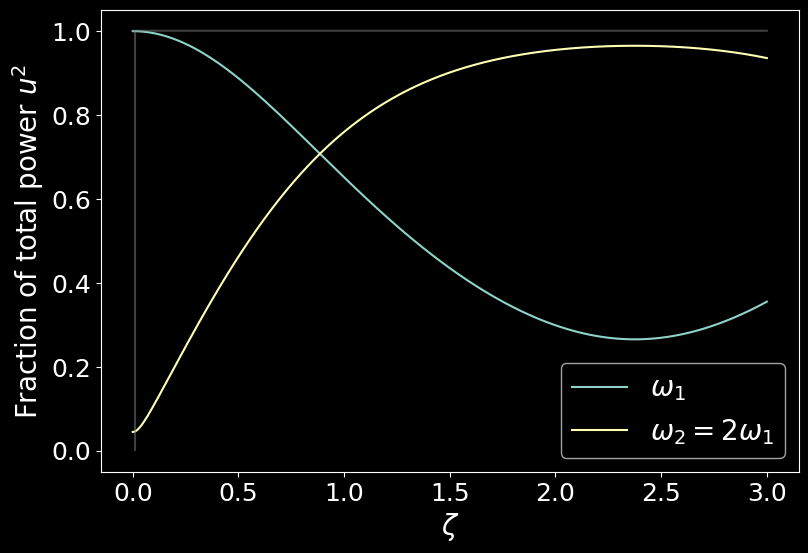

In [23]:
plt.figure(figsize=(9,6))

L = 1e-3/characteristic_length

plt.plot(z, u1, label = r'$\omega_1$')
plt.plot(z,u2, label=r'$\omega_2=2 \omega_1$')
plt.plot(z, u1**2+u2**2, color = 'gray', alpha = 0.5)
plt.vlines(L, 0, 1, color = 'gray', alpha = 0.5)

plt.legend(loc='best', fontsize=20)
plt.xlabel(r'$\zeta$', fontsize = 20)
plt.ylabel(r'Fraction of total power $u^2$', fontsize = 20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.savefig(savedir+'SHG_BBOTheoretical.png', bbox_inches='tight')
plt.show()